In [134]:
#載入所有的模組
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import requests
from bs4 import BeautifulSoup
import numpy as np
import datetime
import os
import io
import warnings
warnings.filterwarnings("ignore")

In [145]:
# 定義爬取函數
def scrape_stock_data_to_csv(stock_code, start_date, output_folder):
    file_date = start_date.strftime('%Y%m')
    start_date=start_date.strftime('%Y%m%d')
    url = f'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=csv&date={start_date}&stockNo={stock_code}'
    response = requests.get(url)
    # 解析 CSV 檔案
    stock_data = pd.read_csv(io.StringIO(response.text), encoding='big5')
    # 構建輸出檔案路徑
    output_file = f'{output_folder}stock_data_{file_date}.csv'
    # 將資料寫入 CSV 檔案
    stock_data.to_csv(output_file, index=True, encoding='big5')
    print(f'Data for {file_date} has been scraped and saved.')

# 指定股票代號、開始日期、結束日期和輸出檔案夾
stock_code = '2330'  # 台積電股票代號
output_folder = f'final/stock_data/{stock_code}/'  # 輸出檔案夾，包含股票代號

# 確保輸出檔案夾存在
os.makedirs(output_folder, exist_ok=True)

# 指定起始日期和結束日期
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2024, 1, 31)

# 迴圈逐月獲取資料
current_date = start_date
while current_date <= end_date:
    # 爬取資料並寫入 CSV 檔案
    scrape_stock_data_to_csv(stock_code, current_date, output_folder)
    # 月份加1
    if current_date.month < 12:
        current_date = datetime.date(current_date.year, current_date.month + 1, 1)
    else:
        current_date = datetime.date(current_date.year + 1, 1, 1)

Data for 202001 has been scraped and saved.
Data for 202002 has been scraped and saved.
Data for 202003 has been scraped and saved.
Data for 202004 has been scraped and saved.
Data for 202005 has been scraped and saved.
Data for 202006 has been scraped and saved.
Data for 202007 has been scraped and saved.
Data for 202008 has been scraped and saved.
Data for 202009 has been scraped and saved.
Data for 202010 has been scraped and saved.
Data for 202011 has been scraped and saved.
Data for 202012 has been scraped and saved.
Data for 202101 has been scraped and saved.
Data for 202102 has been scraped and saved.
Data for 202103 has been scraped and saved.
Data for 202104 has been scraped and saved.
Data for 202105 has been scraped and saved.
Data for 202106 has been scraped and saved.
Data for 202107 has been scraped and saved.
Data for 202108 has been scraped and saved.
Data for 202109 has been scraped and saved.
Data for 202110 has been scraped and saved.
Data for 202111 has been scraped

In [146]:
# 假設 stock_code 是您要讀取的股票代號

stock_code = '2330'

folder_path = f'C:/Users/user/Desktop/python_machine/IMLP347/final/stock_data/{stock_code}/'
all_files = os.listdir(folder_path)

# 存放所有 DataFrame 的清單
dfs = []

# 遍歷所有的檔案
for i, file_name in enumerate(all_files):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path, encoding='big5')
        
        # 如果是第一個文件，將 DataFrame 加入清單
        if i == 0:
            dfs.append(df)
        # 如果不是第一個文件，只將數據部分（不包括標題）加入清單
        else:
            dfs.append(df.iloc[1:])

# 使用 pd.concat 合併所有 DataFrame
result_df = pd.concat(dfs, ignore_index=True)
result_df_select = result_df.iloc[:, [0] + list(range(3, 8))]
result_df_select = result_df_select.iloc[1:, :]
result_df_select = result_df_select[result_df_select.iloc[:, 5] != 'X0.00']
final = result_df_select.dropna()
english_header = ['Date','Open','Max','Min','Close','Diff']
# 保存到 CSV 文件，省略列名
final.to_csv(f'final/stock/{stock_code}.csv', index=False, encoding='big5', header= english_header)

In [147]:
#股市指標計算
# 計算KD值
def calculate_kd(stock_data, n=14):
    stock_data['RSV'] = (stock_data['Close'] - stock_data['Min'].rolling(window=n).min()) / (stock_data['Max'].rolling(window=n).max() - stock_data['Min'].rolling(window=n).min())
    stock_data['K'] = stock_data['RSV'].ewm(span=3, adjust=False).mean()
    stock_data['D'] = stock_data['K'].ewm(span=3, adjust=False).mean()

    # 根據 KD 值生成買入、賣出和持有訊號
    stock_data['KD_diff'] = stock_data['K'] - stock_data['D']

    return stock_data


# 計算MACD
def calculate_macd(stock_data, short_window=12, long_window=26, signal_window=9):
    stock_data['ShortEMA'] = stock_data['Close'].ewm(span=short_window, adjust=False).mean()
    stock_data['LongEMA'] = stock_data['Close'].ewm(span=long_window, adjust=False).mean()
    stock_data['MACD'] = stock_data['ShortEMA'] - stock_data['LongEMA']

    return stock_data

# 計算RSI
def calculate_rsi(stock_data, n=14):
    price_diff = stock_data['Close'].diff(1)
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)
    avg_gain = gain.rolling(window=n, min_periods=1).mean()
    avg_loss = loss.rolling(window=n, min_periods=1).mean()
    rs = avg_gain / avg_loss
    stock_data['RSI'] = 100 - (100 / (1 + rs))
    return stock_data

# 計算移動平均線
def calculate_moving_average(stock_data, n):
    stock_data[f'MA_{n}'] = stock_data['Close'].rolling(window=n).mean()
    return stock_data
#計算趨勢
def calculate_trend_of(stock_data,n,m):
    stock_data[f'MA_{n}_to_{m}'] = stock_data[f'MA_{n}']-stock_data[f'MA_{m}']
    return stock_data
# helper 函數，將年份 + 1911
def convert_to_ROC_year(date_series):
    for i in range(len(date_series)):
        # 將 str 裡的 year 用 replace 的方式把原有的 str 轉成 int + 1911 再轉回 str 型態
        date_series.iloc[i] = date_series.iloc[i].replace(date_series.iloc[i][0:3], str(int(date_series.iloc[i][0:3]) + 1911))
    return date_series
# 計算指標

# 讀取資料
stock_code= '2412'
stock_data = pd.read_csv(f'final/stock/{stock_code}.csv', encoding='big5')
# 將 'Date' 欄位轉換為日期類型
stock_data['Date'] = convert_to_ROC_year(stock_data['Date'])
stock_data = calculate_kd(stock_data)
stock_data = calculate_macd(stock_data)
stock_data = calculate_rsi(stock_data)
stock_data = calculate_moving_average(stock_data,5)
stock_data = calculate_moving_average(stock_data,10)
stock_data = calculate_moving_average(stock_data,20)
stock_data = calculate_trend_of(stock_data,10,20)
stock_data = calculate_trend_of(stock_data,5,20)
stock_data = calculate_trend_of(stock_data,5,10)
stock_data['Price_Change'] = stock_data['Close'].diff().shift(-1)
stock_data_predict = stock_data.dropna()
stock_data_use = stock_data_predict[['Date','Close','Price_Change','MACD','KD_diff', 'RSI', 'MA_5_to_10', 'MA_10_to_20', 'MA_5_to_20']]
stock_data_use.to_csv(f'final/stock/{stock_code}_deal.csv', index=False, encoding='big5')
stock_data_use.head(1000)

,Date,Close,Price_Change,MACD,KD_diff,RSI,MA_5_to_10,MA_10_to_20,MA_5_to_20
19,2020/02/07,20.30,0.10,-0.008034,0.074659,55.172414,0.000,0.0025,0.0025
20,2020/02/10,20.40,-0.10,0.014088,0.067628,55.172414,0.120,-0.0075,0.1125
21,2020/02/11,20.30,-0.25,0.023283,0.032296,51.724138,0.190,-0.0300,0.1600
22,2020/02/12,20.05,0.10,0.010278,-0.026277,45.000000,0.220,-0.0950,0.1250
23,2020/02/13,20.15,0.00,0.007949,-0.017685,45.901639,0.120,-0.0275,0.0925
...,...,...,...,...,...,...,...,...,...
983,2024/01/24,26.60,0.15,-0.065311,0.099236,39.655172,-0.070,-0.3725,-0.4425
984,2024/01/25,26.75,0.20,-0.037842,0.097911,46.428571,0.125,-0.3575,-0.2325
985,2024/01/26,26.95,0.15,0.000066,0.126962,50.847458,0.245,-0.3075,-0.0625
986,2024/01/29,27.10,-0.25,0.041730,0.129270,55.000000,0.355,-0.2425,0.1125


Feature Combination: ['MACD']
  Feature  Importance
0    MACD         1.0

--------------------------------------------------

Feature Combination: ['KD_diff']
   Feature  Importance
0  KD_diff         1.0

--------------------------------------------------

Feature Combination: ['RSI']
  Feature  Importance
0     RSI         1.0

--------------------------------------------------

Feature Combination: ['MA_5_to_20']
      Feature  Importance
0  MA_5_to_20         1.0

--------------------------------------------------

Feature Combination: ['MA_5_to_10']
      Feature  Importance
0  MA_5_to_10         1.0

--------------------------------------------------

Feature Combination: ['MA_10_to_20']
       Feature  Importance
0  MA_10_to_20         1.0

--------------------------------------------------

Feature Combination: ['MACD', 'KD_diff']
   Feature  Importance
1  KD_diff    0.744031
0     MACD    0.255969

--------------------------------------------------

Feature Combination: ['MAC

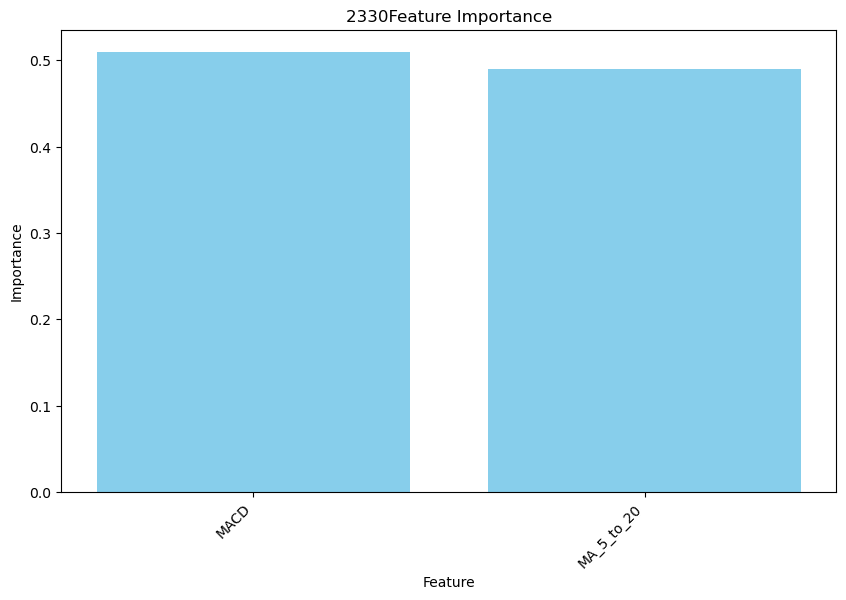

auc: 0.5366013071895425


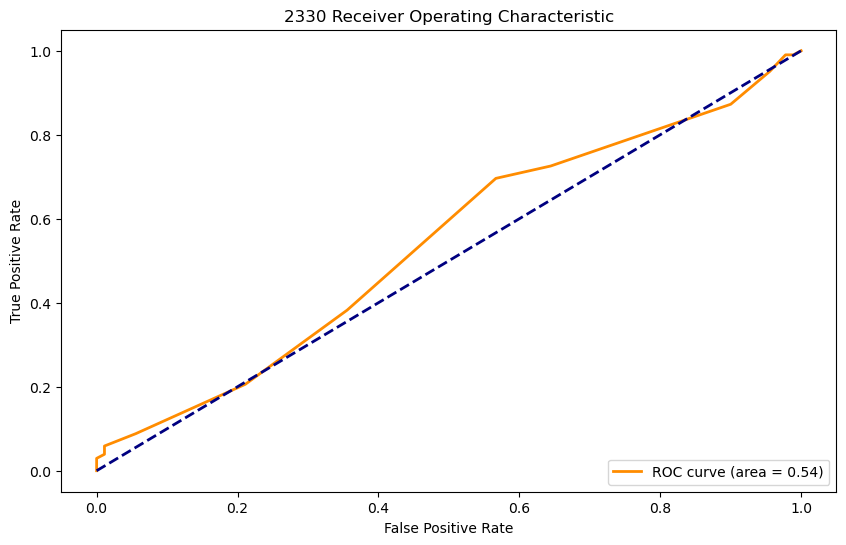

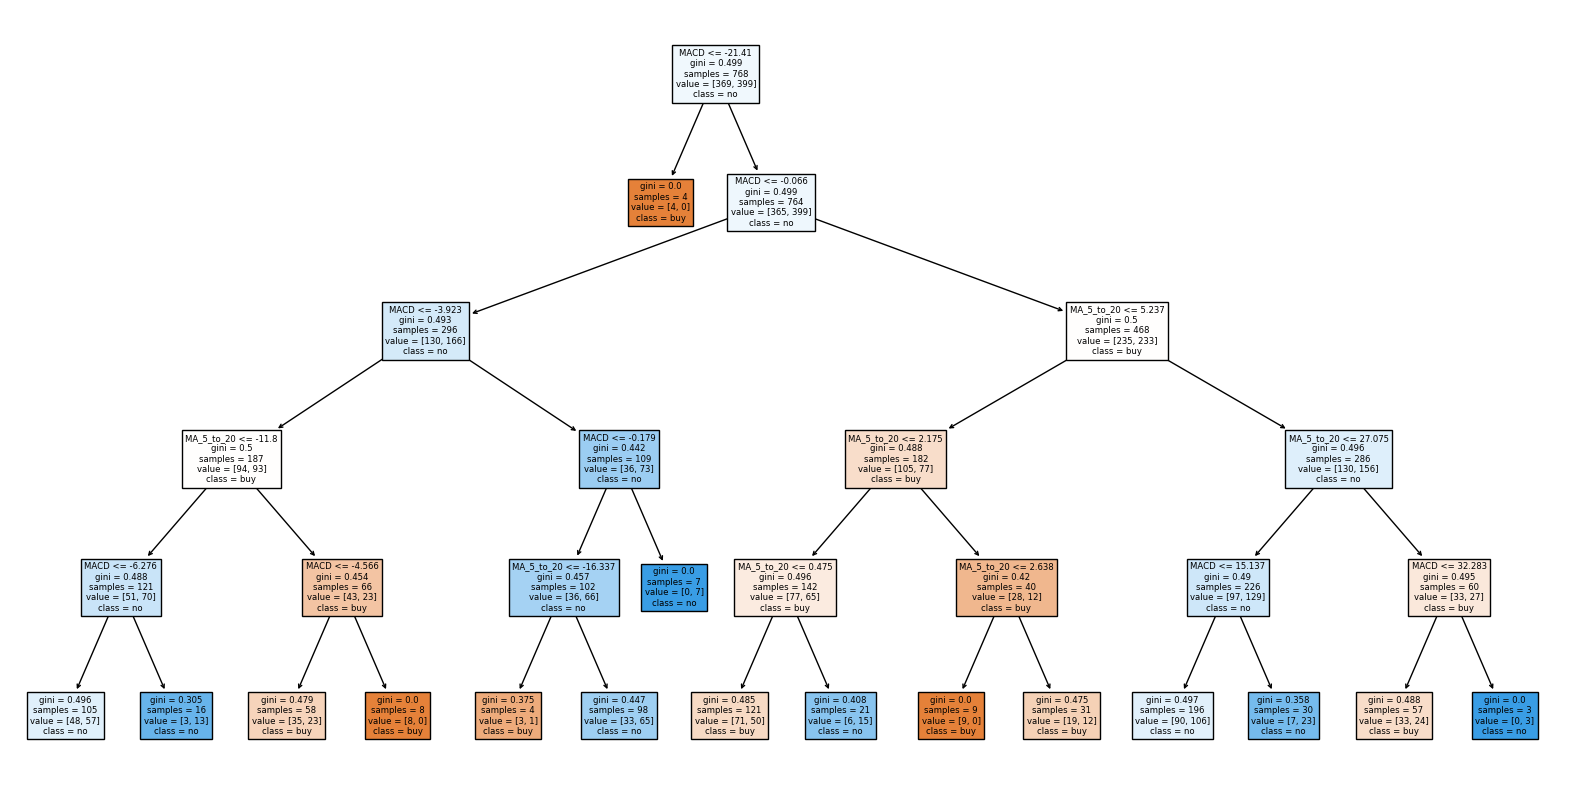

In [181]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# 讀取資料
stoke_number = 2330
data = pd.read_csv(f'final/stock/{stoke_number}_deal.csv', encoding='big5')
data['Price_Change'] = np.where(data['Price_Change'] > 0, 'buy', np.where(data['Price_Change'] <= 0, 'no', 'sell'))

# 提取特徵和目標變數
all_features = ['MACD', 'KD_diff', 'RSI', 'MA_5_to_20', 'MA_5_to_10', 'MA_10_to_20']
target = data['Price_Change']

# 將目標變數轉換為離散的類別標籤
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# 初始化最佳組合和對應的正確率
best_combination = None
best_accuracy = 0.0

# 遍歷所有特徵排列組合的大小（1到len(all_features)）
for r in range(1, len(all_features) + 1):
    # 遍歷所有特徵的排列組合
    for feature_combination in combinations(all_features, r):
        # 提取當前排列組合的特徵和目標變數
        current_features = data[list(feature_combination)]
        X_train, X_test, y_train, y_test = train_test_split(current_features, target_encoded, test_size=0.2, random_state=42)

        # 建立 Decision Tree 模型
        model = DecisionTreeClassifier(random_state=42, max_depth=5)

        # 在標準化後的資料上進行訓練
        model.fit(X_train, y_train)

        # 獲取特徵重要性
        feature_importances = model.feature_importances_

        # 將 best_combination 轉換為 list
        best_combination_list = list(feature_combination)

        # 建立一個包含特徵名稱和其對應重要性的 DataFrame
        feature_importance_df = pd.DataFrame({'Feature': best_combination_list, 'Importance': feature_importances})

        # 根據重要性降序排序
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        # 顯示特徵組合和對應的重要性
        print(f'Feature Combination: {list(feature_combination)}')
        print(feature_importance_df)
        print('\n' + '-'*50 + '\n')

        # 計算正確率
        y_pred = model.predict(X_test)
        current_accuracy = accuracy_score(y_test, y_pred)

        # 如果當前正確率更好，則更新最佳組合和最佳正確率
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_combination = feature_combination

# 顯示最佳組合和對應的正確率
print(f'Best Feature Combination: {best_combination}')
print(f'Best Accuracy: {best_accuracy}')

# 獲取最佳組合的特徵重要性，因為被覆蓋掉了
X_train, X_test, y_train, y_test = train_test_split(data[list(best_combination)], target_encoded, test_size=0.2, random_state=42)
final_model = DecisionTreeClassifier(random_state=42, max_depth=5)
final_model.fit(X_train, y_train)

# 獲取特徵重要性
feature_importance = final_model.feature_importances_

# 將特徵名稱和重要性結合
feature_importance_df = pd.DataFrame({'Feature': best_combination, 'Importance': feature_importance})

# 依重要性降序排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 顯示特徵重要性
print('Feature Importance:')
print(feature_importance_df)

# 繪製特徵重要性柱狀圖
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'{stoke_number}Feature Importance')
plt.xticks(rotation=45, ha='right')  # 使特徵名稱垂直顯示
plt.show()

# 繪製 ROC 曲線
final_y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, final_y_prob)
roc_auc = auc(fpr, tpr)
print(f'auc: {roc_auc}')


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{stoke_number} Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# 繪製決策樹樹狀圖
plt.figure(figsize=(20, 10))
plot_tree(final_model, filled=True, feature_names=list(best_combination), class_names=list(label_encoder.classes_))
plt.show()


Best Feature Combination: ('MACD', 'RSI', 'MA_10_to_20')
Best MSE: 865.3061
Best R-squared: -0.2871

Final Model Coefficients:
       Feature  Coefficient
0         MACD     0.690334
1          RSI     0.232492
2  MA_10_to_20    -0.459406
815   2023-07-03
816   2023-07-04
817   2023-07-05
818   2023-07-06
819   2023-07-07
         ...    
955   2024-01-24
956   2024-01-25
957   2024-01-26
958   2024-01-29
959   2024-01-30
Name: Date, Length: 145, dtype: datetime64[ns]


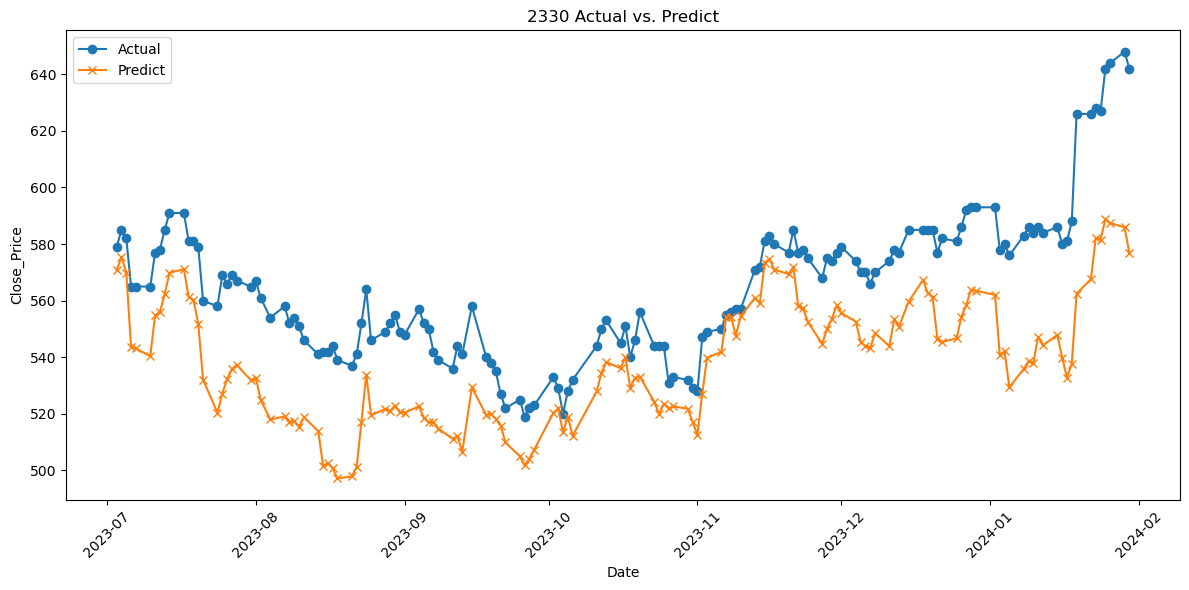

In [166]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator

# 讀取資料
stoke_number = 2330
data = pd.read_csv(f'final/stock/{stoke_number}_deal.csv', encoding='big5')
data['Date'] = pd.to_datetime(data['Date'])  # 將日期轉換為 datetime 格式

# 自行指定訓練資料的日期範圍
train_start_date = '2022-01-01'
train_end_date = '2024-01-31'

# 自行指定測試資料的日期範圍
test_start_date = '2023-07-01'
test_end_date = '2024-01-31'

# 篩選出訓練資料
train_data = data[(data['Date'] >= train_start_date) & (data['Date'] <= train_end_date)]

# 篩選出測試資料
test_data = data[(data['Date'] >= test_start_date) & (data['Date'] <= test_end_date)]

# 所有特徵的組合
all_features = ['MACD', 'KD_diff', 'RSI', 'MA_5_to_20', 'MA_10_to_20', 'MA_5_to_10']

best_mse = float('inf')  # 初始化最好的 MSE
best_r2 = float('-inf')  # 初始化最好的 R-squared
best_feature_combination = None  # 初始化最佳特徵組合

# 嘗試所有特徵的不同組合
for r in range(1, len(all_features) + 1):
    for feature_combination in combinations(all_features, r):
        # 選擇特徵和目標變量
        features_train = train_data[list(feature_combination)]
        target_train = train_data['Close']

        features_test = test_data[list(feature_combination)]
        target_test = test_data['Close']

        # 將特徵和目標變量數據標準化
        scaler_features = StandardScaler()
        features_train_scaled = scaler_features.fit_transform(features_train)
        features_test_scaled = scaler_features.transform(features_test)

        scaler_target = StandardScaler()
        target_train_scaled = scaler_target.fit_transform(target_train.values.reshape(-1, 1)).flatten()

        # 將數據分為訓練集和測試集，是訓練資料再細分
        X_train, X_test, y_train, y_test = train_test_split(features_train_scaled, target_train_scaled, test_size=0.2, random_state=42)
        # 建立並訓練多元回歸模型
        model = LinearRegression()
        model.fit(X_train, y_train)

        # 在測試集上進行預測
        y_pred = model.predict(features_test_scaled)

        # 評估模型性能
        mse = mean_squared_error(target_test, scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten())
        r2 = r2_score(target_test, scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten())

        # 更新最佳結果
        if mse < best_mse:
            best_mse = mse
            best_r2 = r2
            best_feature_combination = feature_combination

# 打印最佳特徵組合和性能指標
print(f'Best Feature Combination: {best_feature_combination}')
print(f'Best MSE: {best_mse:.4f}')
print(f'Best R-squared: {best_r2:.4f}')

# 使用最佳特徵組合訓練模型
features_train_final = train_data[list(best_feature_combination)]
target_train_final = train_data['Close']

features_test_final = test_data[list(best_feature_combination)]
target_test_final = test_data['Close']

# 將特徵和目標變量數據標準化
scaler_features_final = StandardScaler()
features_train_scaled_final = scaler_features_final.fit_transform(features_train_final)
features_test_scaled_final = scaler_features_final.transform(features_test_final)

scaler_target_final = StandardScaler()
target_train_scaled_final = scaler_target_final.fit_transform(target_train_final.values.reshape(-1, 1)).flatten()

# 將數據分為訓練集和測試集
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(features_train_scaled_final, target_train_scaled_final, test_size=0.2, random_state=42)

# 建立並訓練多元回歸模型
model_final = LinearRegression()
model_final.fit(X_train_final, y_train_final)

# 在測試集上進行預測
y_pred_final = model_final.predict(features_test_scaled_final)

# 打印最終模型的係數
coefficients_final = pd.DataFrame({'Feature': features_train_final.columns, 'Coefficient': model_final.coef_})
print('\nFinal Model Coefficients:')
print(coefficients_final)

# 將測試集的預測值轉換回原始尺度
y_pred_original_scale_final = scaler_target_final.inverse_transform(y_pred_final.reshape(-1, 1)).flatten()

# 繪製預測和實際股價的圖表
plt.figure(figsize=(12, 6))
print(test_data['Date'])
plt.plot(test_data['Date'], test_data['Close'], label='Actual', marker='o')
plt.plot(test_data['Date'], y_pred_original_scale_final, label='Predict', marker='x')
plt.title(f'{stoke_number} Actual vs. Predict')
plt.xlabel('Date')
plt.ylabel('Close_Price')
plt.legend()

# 設置 x 坐標軸刻度為每 6 個月一次
locator = MonthLocator(interval=1)
plt.gca().xaxis.set_major_locator(locator)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
